In [ ]:
from google.colab import auth
from collections import Counter
import shutil
from tqdm import tqdm_notebook as tqdm
from random import randint
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

debiased_n1000 = torch.load('/content/drive/MyDrive/weights/debiased_fusion_n1000.pt', map_location=torch.device('cpu'))
debiased_n2000 = torch.load('/content/drive/MyDrive/weights/debiased_fusion_n2000.pt', map_location=torch.device('cpu'))
debiased_n5000 = torch.load('/content/drive/MyDrive/weights/debiased_fusion_n5000.pt', map_location=torch.device('cpu'))
debiased_n3000 = torch.load('/content/drive/MyDrive/weights/debiased_fusion_n3000.pt', map_location=torch.device('cpu'))

In [ ]:
n1000 = torch.load('/content/drive/MyDrive/weights/fusion_n1000.pt', map_location=torch.device('cpu'))
n2000 = torch.load('/content/drive/MyDrive/weights/fusion_n2000.pt', map_location=torch.device('cpu'))
n3000 = torch.load('/content/drive/MyDrive/weights/fusion_n3000.pt', map_location=torch.device('cpu'))
n5000 = torch.load('/content/drive/MyDrive/weights/fusion_n5000.pt', map_location=torch.device('cpu'))

In [ ]:
from transformers import DistilBertModel, AutoTokenizer
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchinfo import summary

bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
resnet = torch.nn.Sequential(*list(resnet50(weights=ResNet50_Weights.DEFAULT).children())[:-1])

# Modified MultiModalModel class to output attention scores from BERT
class MultiModalModel(nn.Module):
    """
    Model that outputs representations for image and text
    """
    def __init__(self, cv_encoder, nlp_encoder, tokenizer):
        super(MultiModalModel, self).__init__()
        self.tokenizer = tokenizer
        self.nlp_encoder = nlp_encoder
        self.nlp_out = nn.Linear(768, 256) # bert
        self.cv_encoder = cv_encoder
        self.cv_out = nn.Linear(2048, 256) # resnet

    def forward(self, im, text, return_attentions=False):
        # Process text
        tokens = self.tokenizer(text, return_tensors="pt", padding='max_length', truncation=True).to(device)
        outputs = self.nlp_encoder(**tokens, output_attentions=return_attentions)
        z_text = outputs.last_hidden_state
        z_text = self.nlp_out(z_text).mean(axis=1)

        if im is not None:
            z_im = self.cv_encoder(im).squeeze()
            z_im = self.cv_out(z_im)
        else:
            z_im = torch.zeros((z_text.shape[0], 256), device=device)  # Placeholder for image features

        if return_attentions:
            attentions = outputs.attentions
            return z_im, z_text, attentions
        return z_im, z_text

# Define the FusionModel class
class FusionModel(nn.Module):
    """
    Model that performs intermediate fusion and outputs logits
    """
    def __init__(self, cv_encoder, nlp_encoder, tokenizer):
        super(FusionModel, self).__init__()
        multimodal_encoder = MultiModalModel(cv_encoder, nlp_encoder, tokenizer)
        self.multimodal_endover = multimodal_encoder
        self.out = nn.Linear(512, 2)

    def forward(self, im, text):
        z_im, z_text = self.multimodal_endover(im, text)
        z = torch.cat([z_im, z_text], axis = 1)
        z = self.out(z)
        return z
    def get_text_attention_scores(self, text):
        # Process only text, image input is None
        _, _, attentions = self.multimodal_endover(None, text, return_attentions=True)
        return attentions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.0MB/s]


In [ ]:
model = FusionModel(resnet, bert, tokenizer)
model.load_state_dict(torch.load('/content/drive/MyDrive/weights/fusion_n3000.pt'))
model = model.to(device)
text_input = "Your example text here."
attention_scores = model.get_text_attention_scores(text_input)


In [ ]:
from transformers import DistilBertModel, AutoTokenizer
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchinfo import summary

def calculate_word_attributions(attentions, tokenizer, text):
    tokenized_text = tokenizer.tokenize(text)
    attn_matrix = attentions[-1].mean(dim=1)  # Use the last layer's attention and average over all heads
    attn_matrix = attn_matrix.squeeze(0)
    attn_scores = attn_matrix.sum(dim=0)

    # Normalize scores
    attn_scores = attn_scores / attn_scores.sum()

    # Pair tokens with their attention scores
    word_attributions = [(token, score.item()) for token, score in zip(tokenized_text, attn_scores)]
    return word_attributions

# Example usage
text_input = "I love you, I like you"
attention_scores = model.get_text_attention_scores(text_input)
word_attributions = calculate_word_attributions(attention_scores, tokenizer, text_input)

print(word_attributions)


[('i', 0.0366610512137413), ('love', 0.01581057347357273), ('you', 0.0413178876042366), (',', 0.062143146991729736), ('i', 0.04280955344438553), ('like', 0.016995584592223167), ('you', 0.03819955140352249)]


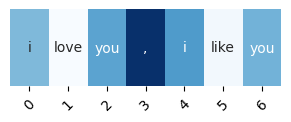

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attributions(word_attributions):
    # Extract tokens and scores
    tokens, scores = zip(*word_attributions)

    # Create a heatmap
    plt.figure(figsize=(len(tokens) * 0.5, 1))
    sns.heatmap([scores], annot=[tokens], fmt="", cmap="Blues", cbar=False, xticklabels=True)
    plt.yticks([])
    plt.xticks(rotation=45)
    plt.show()

visualize_attributions(word_attributions)